In [3]:
import sys
sys.path.append('../../')

from keras.callbacks import EarlyStopping

from src.hypermodels import *
from src.utils  import *
from src.dataset import *

question_id = 4

# Load the data

In [4]:
image_size = 224

# duel_results_path = f'../../data/duel_results/duels_question_{question_id}'
# image_file_dir = '../../data/Mapillary_data/Sample_web_green'
# 
# print(f'Dataset Seed:{dataset_seed}') # For reproducibility, seed is defined using the date and time (e.g. 2021-01-01 12:30:15 -> seed = 20210101123015)

# (x_train, y_train), (x_val, y_val), (x_test, y_test) = prepare_dataset(duel_results_path, 
#                                                                        image_file_dir, 
#                                                                        img_size=image_size,
#                                                                        model_type='ranking',
#                                                                        shuffle=True, 
#                                                                        shuffle_seed=dataset_seed)

# Load from the saved numpy arrays
x1_train,x2_train = np.load('../../data/Q4_Datasets_rs2310111018/x_train.npy')
x1_val,x2_val = np.load('../../data/Q4_Datasets_rs2310111018/x_val.npy')
x1_test,x2_test = np.load('../../data/Q4_Datasets_rs2310111018/x_test.npy')

y_train = np.load('../../data/Q4_Datasets_rs2310111018/y_train.npy')
y_val = np.load('../../data/Q4_Datasets_rs2310111018/y_val.npy')
y_test = np.load('../../data/Q4_Datasets_rs2310111018/y_test.npy')


x_train = [x1_train, x2_train]
x_val = [x1_val, x2_val]
x_test = [x1_test, x2_test]

del x1_train,x2_train,x1_val,x2_val,x1_test,x2_test

dataset_id = 'Q4_Datasets_rs2310111018'

# Data Preprocessing Hyperparameters (Using Keras Preprocessing Layers)

In [5]:
hps_data_preprocessing = {
    'image_preprocessing': {
        'resize': {'height': image_size, 'width': image_size, 'interpolation': 'bicubic'},
        'rescale': {'scale': 1.0 / 255},
    },
    'image_augmentation': {
        'random_rotation': {'factor': 0.4},
        'random_flip': {'mode': 'horizontal_and_vertical'},
        'random_contrast': {'factor': 0.7},
        'random_brightness': {'factor': 0.4, 'value_range': [0.0, 1.0]},
        'random_zoom': {'height_factor': 0.2, 'width_factor': 0.2},
    },
}

image_preprocessing_layers = Sequential(
    [
        layers.Resizing(height=hps_data_preprocessing['image_preprocessing']['resize']['height'],
                     width=hps_data_preprocessing['image_preprocessing']['resize']['width'], 
                     interpolation=hps_data_preprocessing['image_preprocessing']['resize']['interpolation']
                     ),
        layers.Rescaling(scale=hps_data_preprocessing['image_preprocessing']['rescale']['scale'])
    ],
    name='image_preprocessing'
)

image_augmentation_layers = Sequential(
    [
        layers.RandomRotation(factor=hps_data_preprocessing['image_augmentation']['random_rotation']['factor']),
        layers.RandomFlip(mode=hps_data_preprocessing['image_augmentation']['random_flip']['mode']),
        layers.RandomContrast(factor=hps_data_preprocessing['image_augmentation']['random_contrast']['factor']),
        layers.RandomBrightness(factor=hps_data_preprocessing['image_augmentation']['random_brightness']['factor'],
                                value_range=hps_data_preprocessing['image_augmentation']['random_brightness']['value_range']),
        layers.RandomZoom(height_factor=hps_data_preprocessing['image_augmentation']['random_zoom']['height_factor'],
                          width_factor=hps_data_preprocessing['image_augmentation']['random_zoom']['width_factor'])
    ],
    name='image_augmentation'
)

# Model Training Hyperparameters

In [6]:
hps_model_training = {'optimizer': 'adam',
                      'learning_rate': 0.0001,
                      'loss': 'binary_crossentropy',
                      'metrics': ['accuracy'],
                      'batch_size': 64,
                      'epochs': 30,
                      }

# Model Architecture Hyperparameters

In [13]:
hp_model_architecture = {
    'feature_extractor': 'vgg19',
    'num_dense_layers': 2,
    'dense_units': [32,32],
    'dense_dropout_rates': [0.3, 0.3],
    'dense_activation': ['relu', 'relu'],
    'ranking_score_activation': 'linear',
    'final_activation': 'sigmoid',
}

# Train the model

In [14]:
meta_model = create_siamese_network(img_size=image_size,
                                    image_preprocessing_layers=image_preprocessing_layers,
                                    image_augmentation_layers=image_augmentation_layers,
                                    feature_extractor=hp_model_architecture['feature_extractor'],
                                    num_dense_layers=hp_model_architecture['num_dense_layers'], 
                                    dense_units_list=hp_model_architecture['dense_units'],
                                    dense_activation_list=hp_model_architecture['dense_activation'],
                                    dropout_rate_list=hp_model_architecture['dense_dropout_rates'],
                                    ranking_score_activation=hp_model_architecture['ranking_score_activation'],
                                    final_activation=hp_model_architecture['final_activation'],
                                    unfreeze_layers = 4, # Fine-tune the last 4 layers of the VGG19
                                    pretrained_weights = 'imagenet' # Use the pre-trained weights of the VGG19
                                    )

meta_model.compile(optimizer=hps_model_training['optimizer'],
                   loss=hps_model_training['loss'],
                   metrics=hps_model_training['metrics'])

history = meta_model.fit(
    x=x_train,
    y=y_train,
    batch_size=hps_model_training['batch_size'],
    epochs=hps_model_training['epochs'],
    validation_data=(x_val, y_val),
    callbacks=[EarlyStopping(monitor='val_accuracy',
                             patience=8,
                             verbose=1,
                             restore_best_weights=True)],
    verbose=1,
)


Epoch 1/30
42/42 [==============================] - 8s 182ms/step - loss: 0.9017 - accuracy: 0.5492 - val_loss: 0.7089 - val_accuracy: 0.5955
Epoch 2/30
42/42 [==============================] - 7s 163ms/step - loss: 0.7593 - accuracy: 0.6155 - val_loss: 0.7747 - val_accuracy: 0.5966
Epoch 3/30
42/42 [==============================] - 7s 163ms/step - loss: 0.7007 - accuracy: 0.6376 - val_loss: 0.6495 - val_accuracy: 0.6596
Epoch 4/30
42/42 [==============================] - 7s 163ms/step - loss: 0.6737 - accuracy: 0.6481 - val_loss: 0.6321 - val_accuracy: 0.6697
Epoch 5/30
42/42 [==============================] - 7s 163ms/step - loss: 0.6263 - accuracy: 0.6866 - val_loss: 0.6218 - val_accuracy: 0.6809
Epoch 6/30
42/42 [==============================] - 7s 162ms/step - loss: 0.6206 - accuracy: 0.6747 - val_loss: 0.7558 - val_accuracy: 0.6652
Epoch 7/30
42/42 [==============================] - 7s 163ms/step - loss: 0.5704 - accuracy: 0.7151 - val_loss: 0.6000 - val_accuracy: 0.6899
Epoch 

# Save the model and the training results

Hyperparams saved!
Model history saved to csv!
Model architecture saved!
Model weights saved!
Model saved to keras!
Figure Training and ValidationLoss saved!


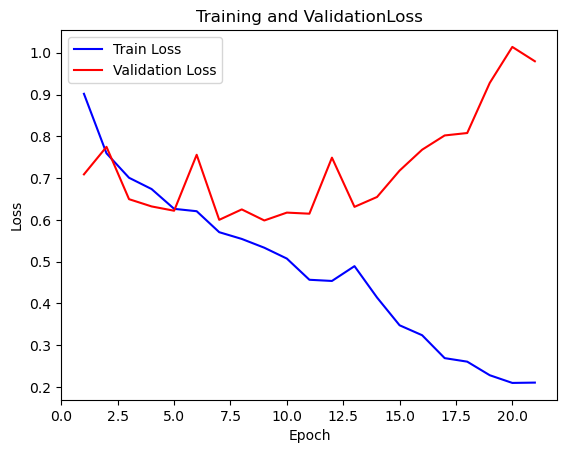

Figure Training and ValidationAccuracy saved!


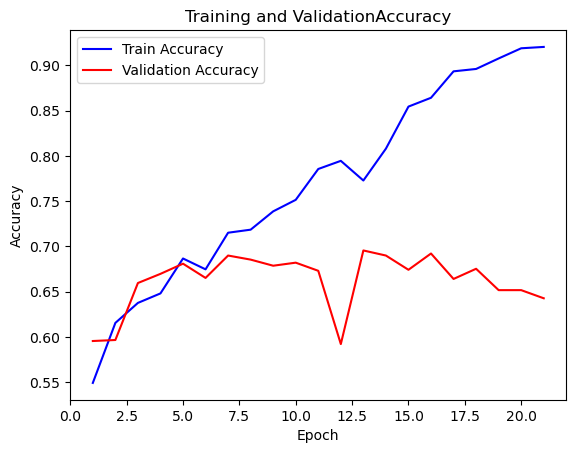

In [15]:
# Save the training results of meta_model
from src.utils import safe_save_training_results

best_val_acc = max(history.history['val_accuracy'])
model_save_dir = 'baseline_models/Ranking_VGG19_BestValAcc{:.4f}_{}'.format(best_val_acc,dataset_id)

safe_save_training_results(hyperparams_dict={'model_architecture': hp_model_architecture,
                                             'model_training': hps_model_training,
                                             'data_preprocessing': hps_data_preprocessing},
                           model=meta_model,
                           model_save_type='keras', 
                           history=history,   
                           his_save_type='csv', 
                           save_dir = model_save_dir,)

# Save the plot
plot_model_metrics(history, ['loss', 'accuracy'], save_dir=model_save_dir)